In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **PREPROCESSING**


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from PIL import Image



In [ ]:
data_path = '/content/drive/MyDrive/data1/origin'
output_folder = "/content/drive/MyDrive/cropped"
labels_file = '/content/drive/MyDrive/data/label/label.lst'

In [ ]:
import pandas as pd
dataframe = pd.read_csv(labels_file, sep=" ", header=None)
col_names = "image_name face_id_in_image face_box_top face_box_left face_box_right face_box_bottom face_box_cofidence expression_label".split()
dataframe.columns = col_names
dataframe

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_cofidence,expression_label
0,angry_actor_104.jpg,0,28,113,226,141,22.9362,0
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,0
2,angry_actor_120.jpg,1,53,53,372,372,13.9434,2
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,3
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,0
...,...,...,...,...,...,...,...,...
91788,surprised_expression_546.jpg,0,70,70,351,351,37.7117,5
91789,surprised_expression_381.jpg,0,51,61,117,107,91.6307,5
91790,surprised_expression_395.jpg,0,27,95,258,190,96.2861,5
91791,ecstatic_asian_31.jpg,0,60,136,184,108,39.9223,3


# **CROPPING IMAGES**

In [ ]:
import os
import cv2
from tqdm import tqdm_gui

all_images = []
all_labels = []
all_confidences = []

for i, row in dataframe.iterrows():
    image_name = row["image_name"]
    x1 = row["face_box_left"]
    x2 = row["face_box_right"]
    y1 = row["face_box_top"]
    y2 = row["face_box_bottom"]
    label = row["expression_label"]
    confidence = row["face_box_cofidence"]

    if confidence < 60:
        continue  # Skip images with confidence less than 60

    combined_filename = os.path.join(data_path, image_name)
    img = cv2.imread(combined_filename)

    if img is not None:
        cropped_img = img[y1:y2, x1:x2]
        print(f"Face shape: {cropped_img.shape}, x1={x1}, x2={x2}, y1={y1}, y2={y2}")
    else:
        continue

    if cropped_img is not None:
        face_resized = cv2.resize(cropped_img, (64, 64))
    else:
        continue

    all_images.append(face_resized)
    all_labels.append(label)
    all_confidences.append(confidence)

Streaming output truncated to the last 5000 lines.
Face shape: (114, 114, 3), x1=1000, x2=1114, y1=276, y2=390
Face shape: (162, 162, 3), x1=392, x2=554, y1=54, y2=216
Face shape: (80, 80, 3), x1=247, x2=327, y1=20, y2=100
Face shape: (80, 80, 3), x1=303, x2=383, y1=40, y2=120
Face shape: (160, 160, 3), x1=294, x2=454, y1=0, y2=160
Face shape: (67, 67, 3), x1=163, x2=230, y1=158, y2=225
Face shape: (68, 68, 3), x1=261, x2=329, y1=96, y2=164
Face shape: (161, 161, 3), x1=606, x2=767, y1=188, y2=349
Face shape: (229, 229, 3), x1=498, x2=727, y1=172, y2=401
Face shape: (324, 324, 3), x1=324, x2=648, y1=54, y2=378
Face shape: (67, 67, 3), x1=1180, x2=1247, y1=740, y2=807
Face shape: (112, 112, 3), x1=112, x2=224, y1=47, y2=159
Face shape: (322, 322, 3), x1=564, x2=886, y1=483, y2=805
Face shape: (67, 67, 3), x1=214, x2=281, y1=260, y2=327
Face shape: (80, 80, 3), x1=343, x2=423, y1=437, y2=517
Face shape: (115, 115, 3), x1=86, x2=201, y1=38, y2=153
Face shape: (768, 768, 3), x1=704, x2=147

In [ ]:
print(len(all_images))
print(len(all_labels))

8804
8804


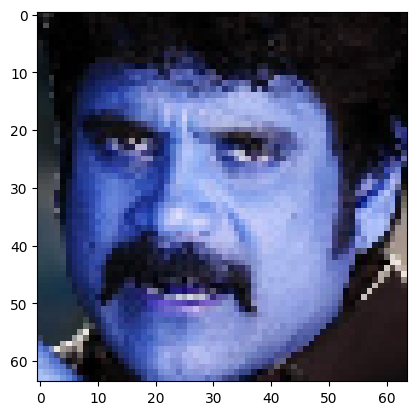

In [ ]:
import matplotlib.pyplot as plt
for i in range(5):
  plt.imshow(all_images[i])

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# **ARGUMENTATION**

In [ ]:
# Convert lists to NumPy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Normalize pixel values to the range [0, 1]
all_faces = all_images.astype('float32') / 255.0

# One-hot encode the expression labels
all_labels = to_categorical(all_labels, num_classes=7)

# Split the dataset into training, validation, and test sets (70%, 15%, 15%)
X_train, X_temp, y_train, y_temp = train_test_split(all_faces, all_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Print the shapes of the data splits
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6162, 64, 64, 3)
y_train shape: (6162, 7)
X_val shape: (1321, 64, 64, 3)
y_val shape: (1321, 7)
X_test shape: (1321, 64, 64, 3)
y_test shape: (1321, 7)


# **Build the CNN model**

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

# Set the input shape based on the cropped face dimensions
img_height, img_width, img_channels = all_faces.shape[1:]

# Build the CNN model

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Schedule and Early Stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Set batch size and number of epochs
batch_size = 32
epochs = 50

# **TRAINING MODEL**

Epoch 1/50
192/192 [==============================] - 25s 53ms/step - loss: 1.3326 - accuracy: 0.5504 - val_loss: 1.3093 - val_accuracy: 0.5367 - lr: 0.0010
Epoch 2/50
192/192 [==============================] - 9s 49ms/step - loss: 1.2439 - accuracy: 0.5659 - val_loss: 1.2491 - val_accuracy: 0.5640 - lr: 0.0010
Epoch 3/50
192/192 [==============================] - 9s 48ms/step - loss: 1.1958 - accuracy: 0.5834 - val_loss: 1.1986 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 4/50
192/192 [==============================] - 8s 41ms/step - loss: 1.1733 - accuracy: 0.5902 - val_loss: 1.1526 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 5/50
192/192 [==============================] - 9s 48ms/step - loss: 1.1256 - accuracy: 0.6015 - val_loss: 1.0811 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 6/50
192/192 [==============================] - 9s 46ms/step - loss: 1.1017 - accuracy: 0.6044 - val_loss: 1.0448 - val_accuracy: 0.6344 - lr: 0.0010
Epoch 7/50
192/192 [==============================] - 8s 39ms/s

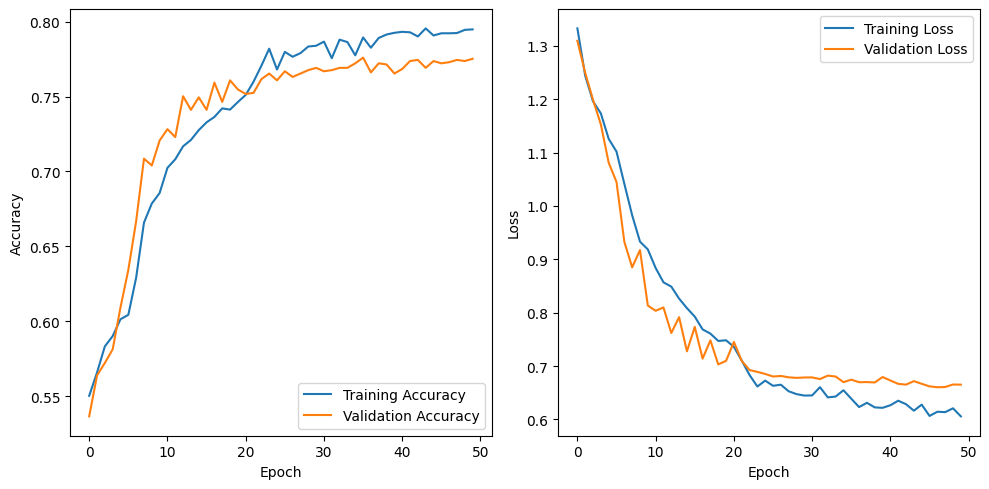

In [ ]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stop])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Analyze the results
# Plot accuracy and loss curves during training
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# **Confution Matrix**

42/42 [==============================] - 0s 3ms/step


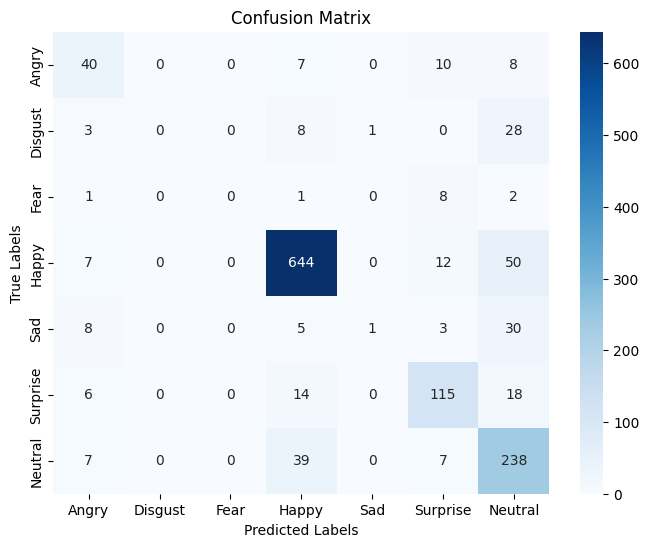

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Get the model predictions on the test set
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **SAVING MODEL**

In [ ]:
# Save the entire model
model.save('facial_expression_model.h5')

# Save only the model's architecture and weights
model_json = model.to_json()
with open('facial_expression_model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('facial_expression_model_weights.h5')